In [50]:
from torch.utils import data
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
from torch.utils.data import random_split
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [2]:
class H5Dataset(Dataset):
    def __init__(self, h5file, transform=None, target_transform=None) -> None:
        super().__init__()
        self.h5file = h5file
        self.transform = transform
        self.target_transform = target_transform

        f = h5py.File(h5file, 'r')
        self.images = np.swapaxes(np.array(f['images']), 1, 3)
        self.labels = np.array(f['ans'])
        
        self.images = self.images.astype(np.float32)
        self.labels = self.labels.astype(np.int)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)

        return img, label

In [3]:
dataset = H5Dataset('Galaxy10_DECals.h5')
len_train = int(0.7 * len(dataset))
len_test = int(0.2 * len(dataset))
len_validation = len(dataset) - len_train - len_test
train_dataset, test_datset, validation_dataset = random_split(dataset, [len_train, len_test, len_validation], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_datset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=True)

classes = ('Disturbed Galaxies', 'Merging Galaxies', 'Round Smooth Galaxies', 'In-between Round Smooth Galaxies', 'Cigar Shaped Smooth Galaxies', 'Barred Spiral Galaxies', 'Unbarred Tight Spiral Galaxies', 'Unbarred Loose Spiral Galaxies', 'Edge-on Galaxies without Bulge', 'Edge-on Galaxies with Bulge')

/tmp/ipykernel_1437071/1405947361.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = self.labels.astype(np.int)


/tmp/ipykernel_1437071/3687583544.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.imshow(np.swapaxes(images.numpy().astype(np.int), 1, 3)[0])


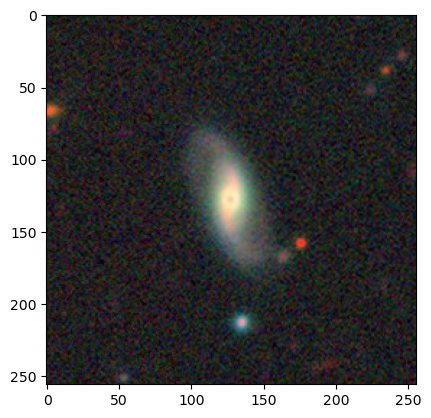

In [4]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
plt.imshow(np.swapaxes(images.numpy().astype(np.int), 1, 3)[0])
plt.show()

In [6]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /net/nfshome/home/sfroese/.cache/torch/hub/pytorch_vision_v0.10.0


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
for epoch in range(10):  # loop over the dataset multiple times
    print(epoch)
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

0
1
2
3
4
5
6
7
8
9
Finished Training


In [12]:
loss

tensor(0.8122, device='cuda:0', grad_fn=<NllLossBackward0>)

In [47]:
correct = 0
total = 0
y_pred = []
y_true = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        
        y_true.extend(labels.data.cpu().numpy())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 77 %


In [48]:
cf_matrix = confusion_matrix(y_true, y_pred)

<Axes: >

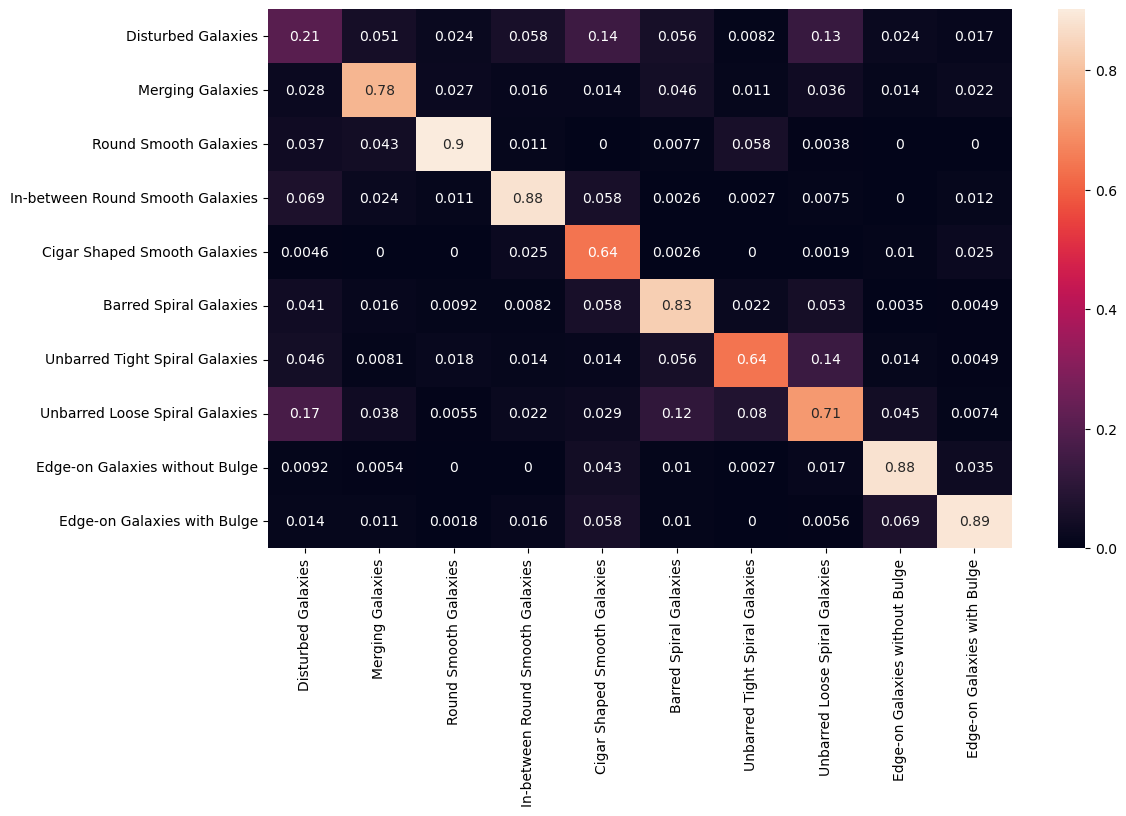

In [51]:
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)